# California Housing Prices
- **Features**:
    - `longitude`: A measure of how far west a house is; a higher value is farther west
    - `latitude`: A measure of how far north a house is; a higher value is farther north
    - `housing_median_age`: Median age of a house within a block; a lower number is a newer building
    - `total_rooms`: Total number of rooms within a block
    - `total_bedrooms`: Total number of bedrooms within a block
    - `population`: Total number of people residing within a block
    - `households`: Total number of households, a group of people residing within a home unit, for a block
    - `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
    - `ocean_proximity`: Location of the house w.r.t ocean/sea
- **Target variable**:
    - `median_house_value`: Median house value for households within a block (measured in US Dollars)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import stats

# optuna
import optuna

from typing import List
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../../../data/common_datasets/housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
type(df.columns)

pandas.core.indexes.base.Index

In [7]:
target_col = 'median_house_value'

# Select numeric columns only
numerical_cols = [cname for cname in df.select_dtypes(include=np.number).columns.drop(target_col)]
# print(f"Numerical Features  : {numerical_cols}")
# Categorical columns in the training data
categorical_cols = [col for col in df.select_dtypes(exclude=np.number).columns]
# print(f"Categorical Features: {object_cols}")


- Conclusion:
    - Numerical Features  : `['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']`
        - TODO: need to identify Numerical (Discrete) Features
    - Categorical Features: `['ocean_proximity']`
    - Target Feature: `'median_house_value'`

## Sanity Check

### Missing/null values

In [8]:
df.isna().sum()*100 / df.shape[0]

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

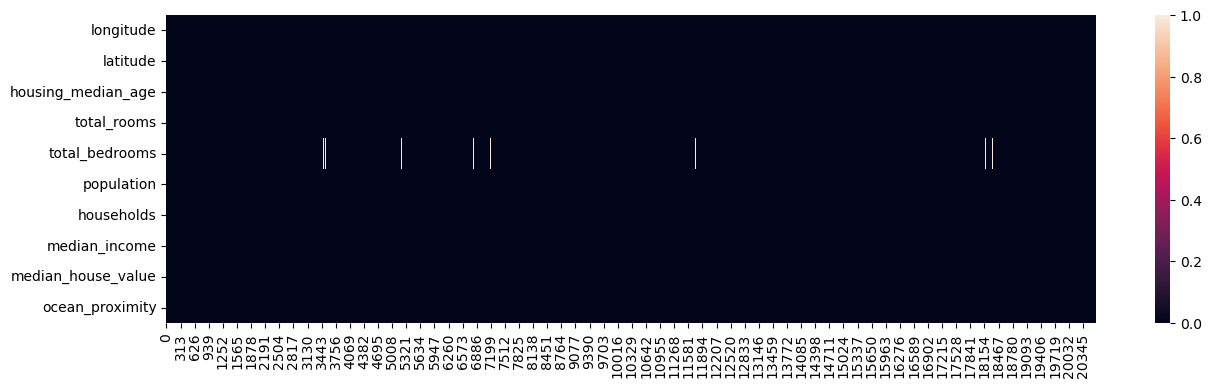

In [9]:
#Showing missing data at which index of the data
fig, ax = plt.subplots(figsize=(15,4)) 
sns.heatmap(df.isna().transpose(), ax=ax)
plt.show()

### Duplication

In [10]:
df.duplicated().sum()

0

- Conclusion:
    - Missing value: `total_bedrooms` has 1% of the data is being missed
        - Solution: `ffill`, `most_freq`
    - Duplication: there is no duplication

## EDA
### Observation
#### Target variable
- Long-tail distribution as very few house with high prices: `np.log1p(df['median_house_value'])`
- However, there is a high concentration of the houses == 500001.0.
#### Features
- Categorical:
    - `ocean_proximity` 
        - has very less value for `ISLAND`
        - The house INLAND is the least expensive, those nearer to ocean/bay will be more expensive, and the most exp one is on ISLAND.
- Numerical:
    - Long-tail distribution (when values far from the mean): `['total_rooms','total_bedrooms', 'population', 'households']`
        - Both min-max scaling and standardization will squash most values into a small range. Machine learning models generally don’t like this at all
        - Before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical. 
        - Before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical. 
        - Solution 1: 
            - Square root (or raise the feature to a power between 0 and 1).
            - If the feature has a really long and heavy tail, such as a **power law distribution**, then replacing the feature with its `logarithm`
            - Bucketizing the feature: chopping its distribution into roughly equal-sized buckets, and replacing each feature value with the index of the bucket it belongs to.         
                - Bucketizing with equal-sized buckets results in a feature with an almost uniform distribution, so there’s no need for further scaling, or you can just divide by the number of buckets to force the values to the 0–1 range.
                - NO need for further scaling, or you can just divide by the number of buckets to force the values to the 0–1 range.
    -  **Multimodal** distribution (i.e., with two or more clear peaks, called modes): `housing_median_age` 
        - Solution 1: bucketize it, but treating the bucket IDs as **categories**, rather than as numerical values. This means that the bucket indices must be encoded
            - For example using a `OneHotEncoder` (so you usually don’t want to use too many buckets). This approach will allow the regression model to more easily learn different rules for different ranges of this feature value. 
        - Solution 2: to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. 
            - The similarity measure is typically computed using a **Radial Basis Function** (RBF)
                - For example: using Scikit-Learn’s rbf_kernel() function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35
    - `['total_rooms','total_bedrooms', 'population', 'households']` are highly correlated to each other
        - This is multicollinearity
    - `'longitude', 'latitude'` are negatively correlated to each other
    - `median_income` is correlated to the target &#8594; binning
- Outliers: Only need to remove the data above `Q3 + 1.5*IQR` only
    - `['total_rooms','total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']`


In [11]:
def plot_dist(df, xlabel='Price'):
    df = df[xlabel]
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(df, bins=40, ax=ax1)
    ax1.set(title='Histogram', ylabel='Frequency', xlabel=xlabel)
    
    #Get also the QQ-plot
    stats.probplot(df, plot=ax2)
    ax2.set_title('Q-Q Plot')
    plt.show()

### Target Variable `median_house_value`
- Long-tail distribution as very few house with high prices: `np.log1p(df['median_house_value'])`
- However, there is a high concentration of the houses == 500001.0.

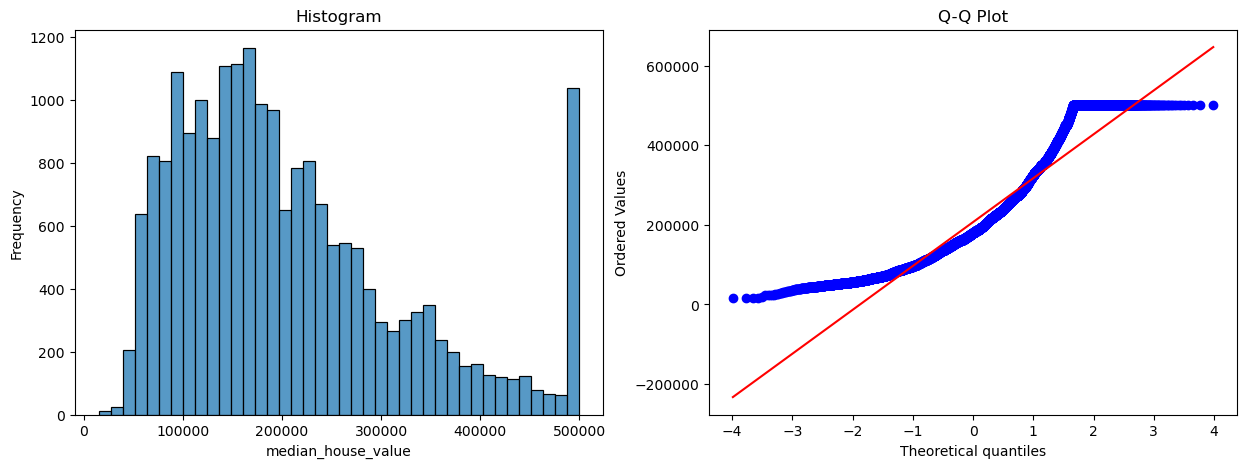

In [12]:
plot_dist(df, xlabel='median_house_value')

In [13]:
df.query('median_house_value == 500001.0').shape[0]

965

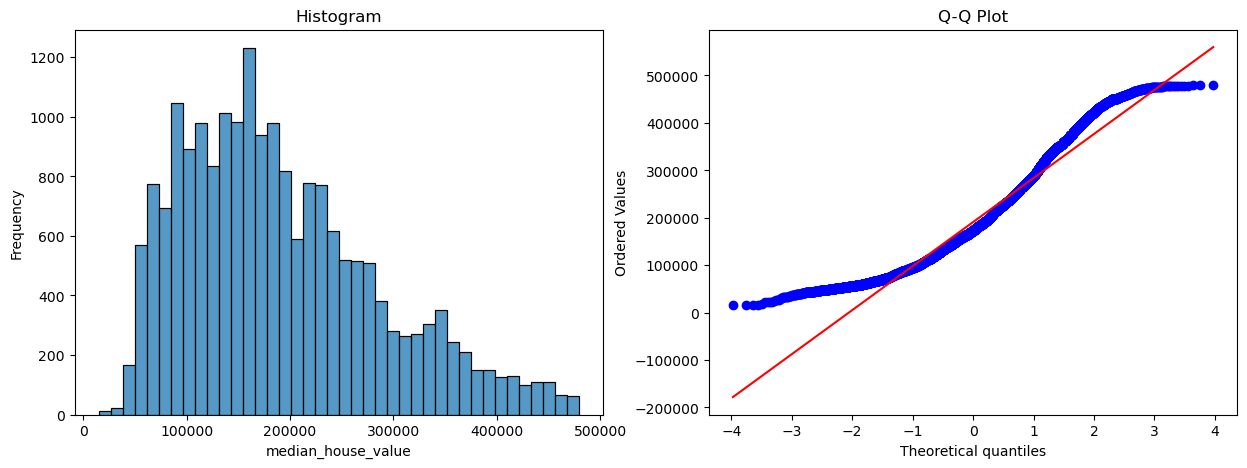

In [14]:
plot_dist(df.query('median_house_value < 480_000'), 'median_house_value')

### Features

#### Categorical Features or Numerical (Discrete) Features

In [15]:
def plot_count(df, col_name, sort=False, rotation=0, figsize=(12,4)):
    _, ax = plt.subplots(figsize=figsize)
    order = df[col_name].value_counts().index if sort else None
    sns.countplot(data=df, x=col_name, ax=ax, order = order)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=rotation, ha='right')
    plt.show()

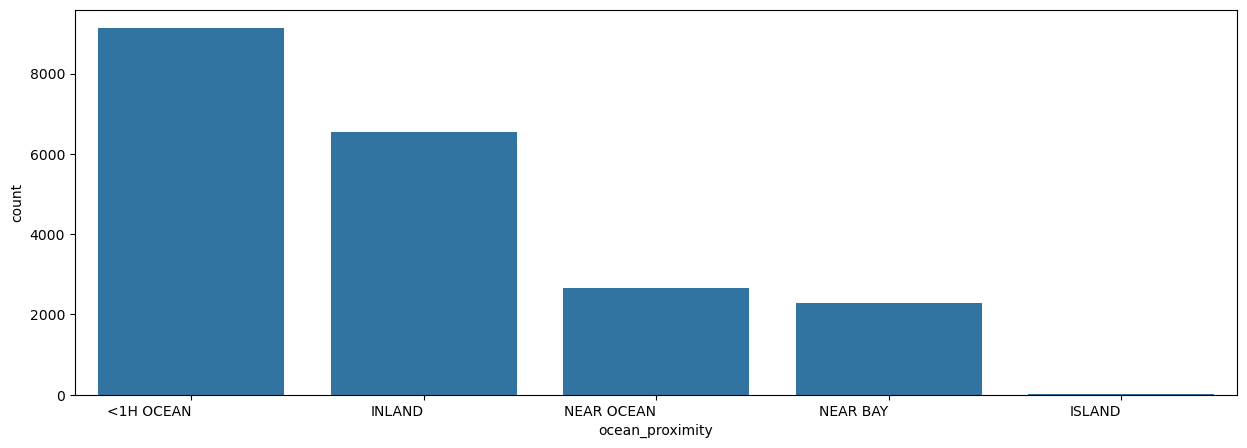

In [16]:
# ocean_proximity
plot_count(df, 'ocean_proximity', sort=True, figsize=(15,5))

In [17]:
df[df['ocean_proximity'] == 'ISLAND']

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,ISLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND
8316,-118.32,33.33,52.0,2127.0,512.0,733.0,288.0,3.3906,300000.0,ISLAND
8317,-118.32,33.34,52.0,996.0,264.0,341.0,160.0,2.7361,450000.0,ISLAND
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,287500.0,ISLAND


In [18]:
summary_df = df.groupby('ocean_proximity')['median_house_value'] \
                .agg(['mean', 'median','std']) \
                .sort_values('mean')
summary_df

,mean,median,std
ocean_proximity,,,
INLAND,124805.392001,108500.0,70007.908494
<1H OCEAN,240084.285464,214850.0,106124.292213
NEAR OCEAN,249433.977427,229450.0,122477.145927
NEAR BAY,259212.311790,233800.0,122818.537064
ISLAND,380440.000000,414700.0,80559.561816


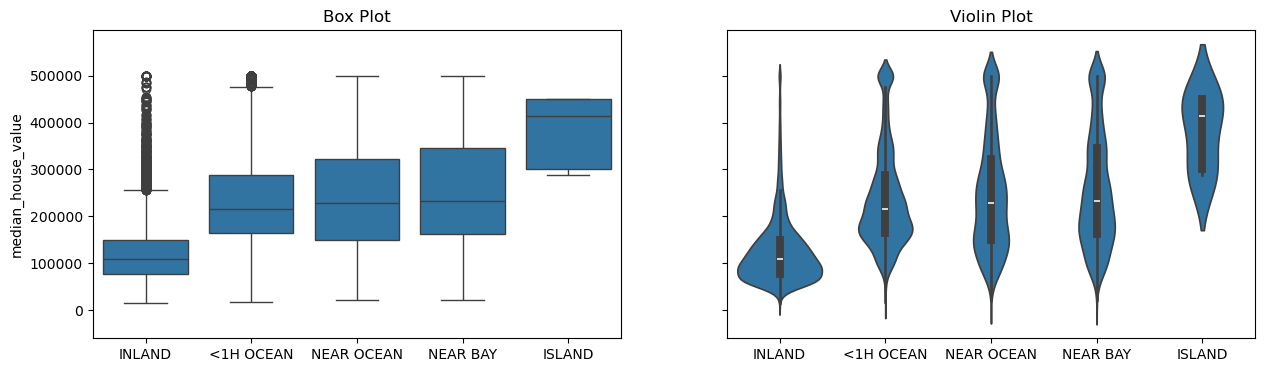

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharey=True)
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value', 
            order=summary_df.index.to_list(), ax=ax1)
ax1.set(xlabel='', title='Box Plot')

sns.violinplot(data=df, x='ocean_proximity', y='median_house_value', 
            order=summary_df.index.to_list(), ax=ax2)
ax2.set(xlabel='', title='Violin Plot')

plt.show()

#### Numerical Features

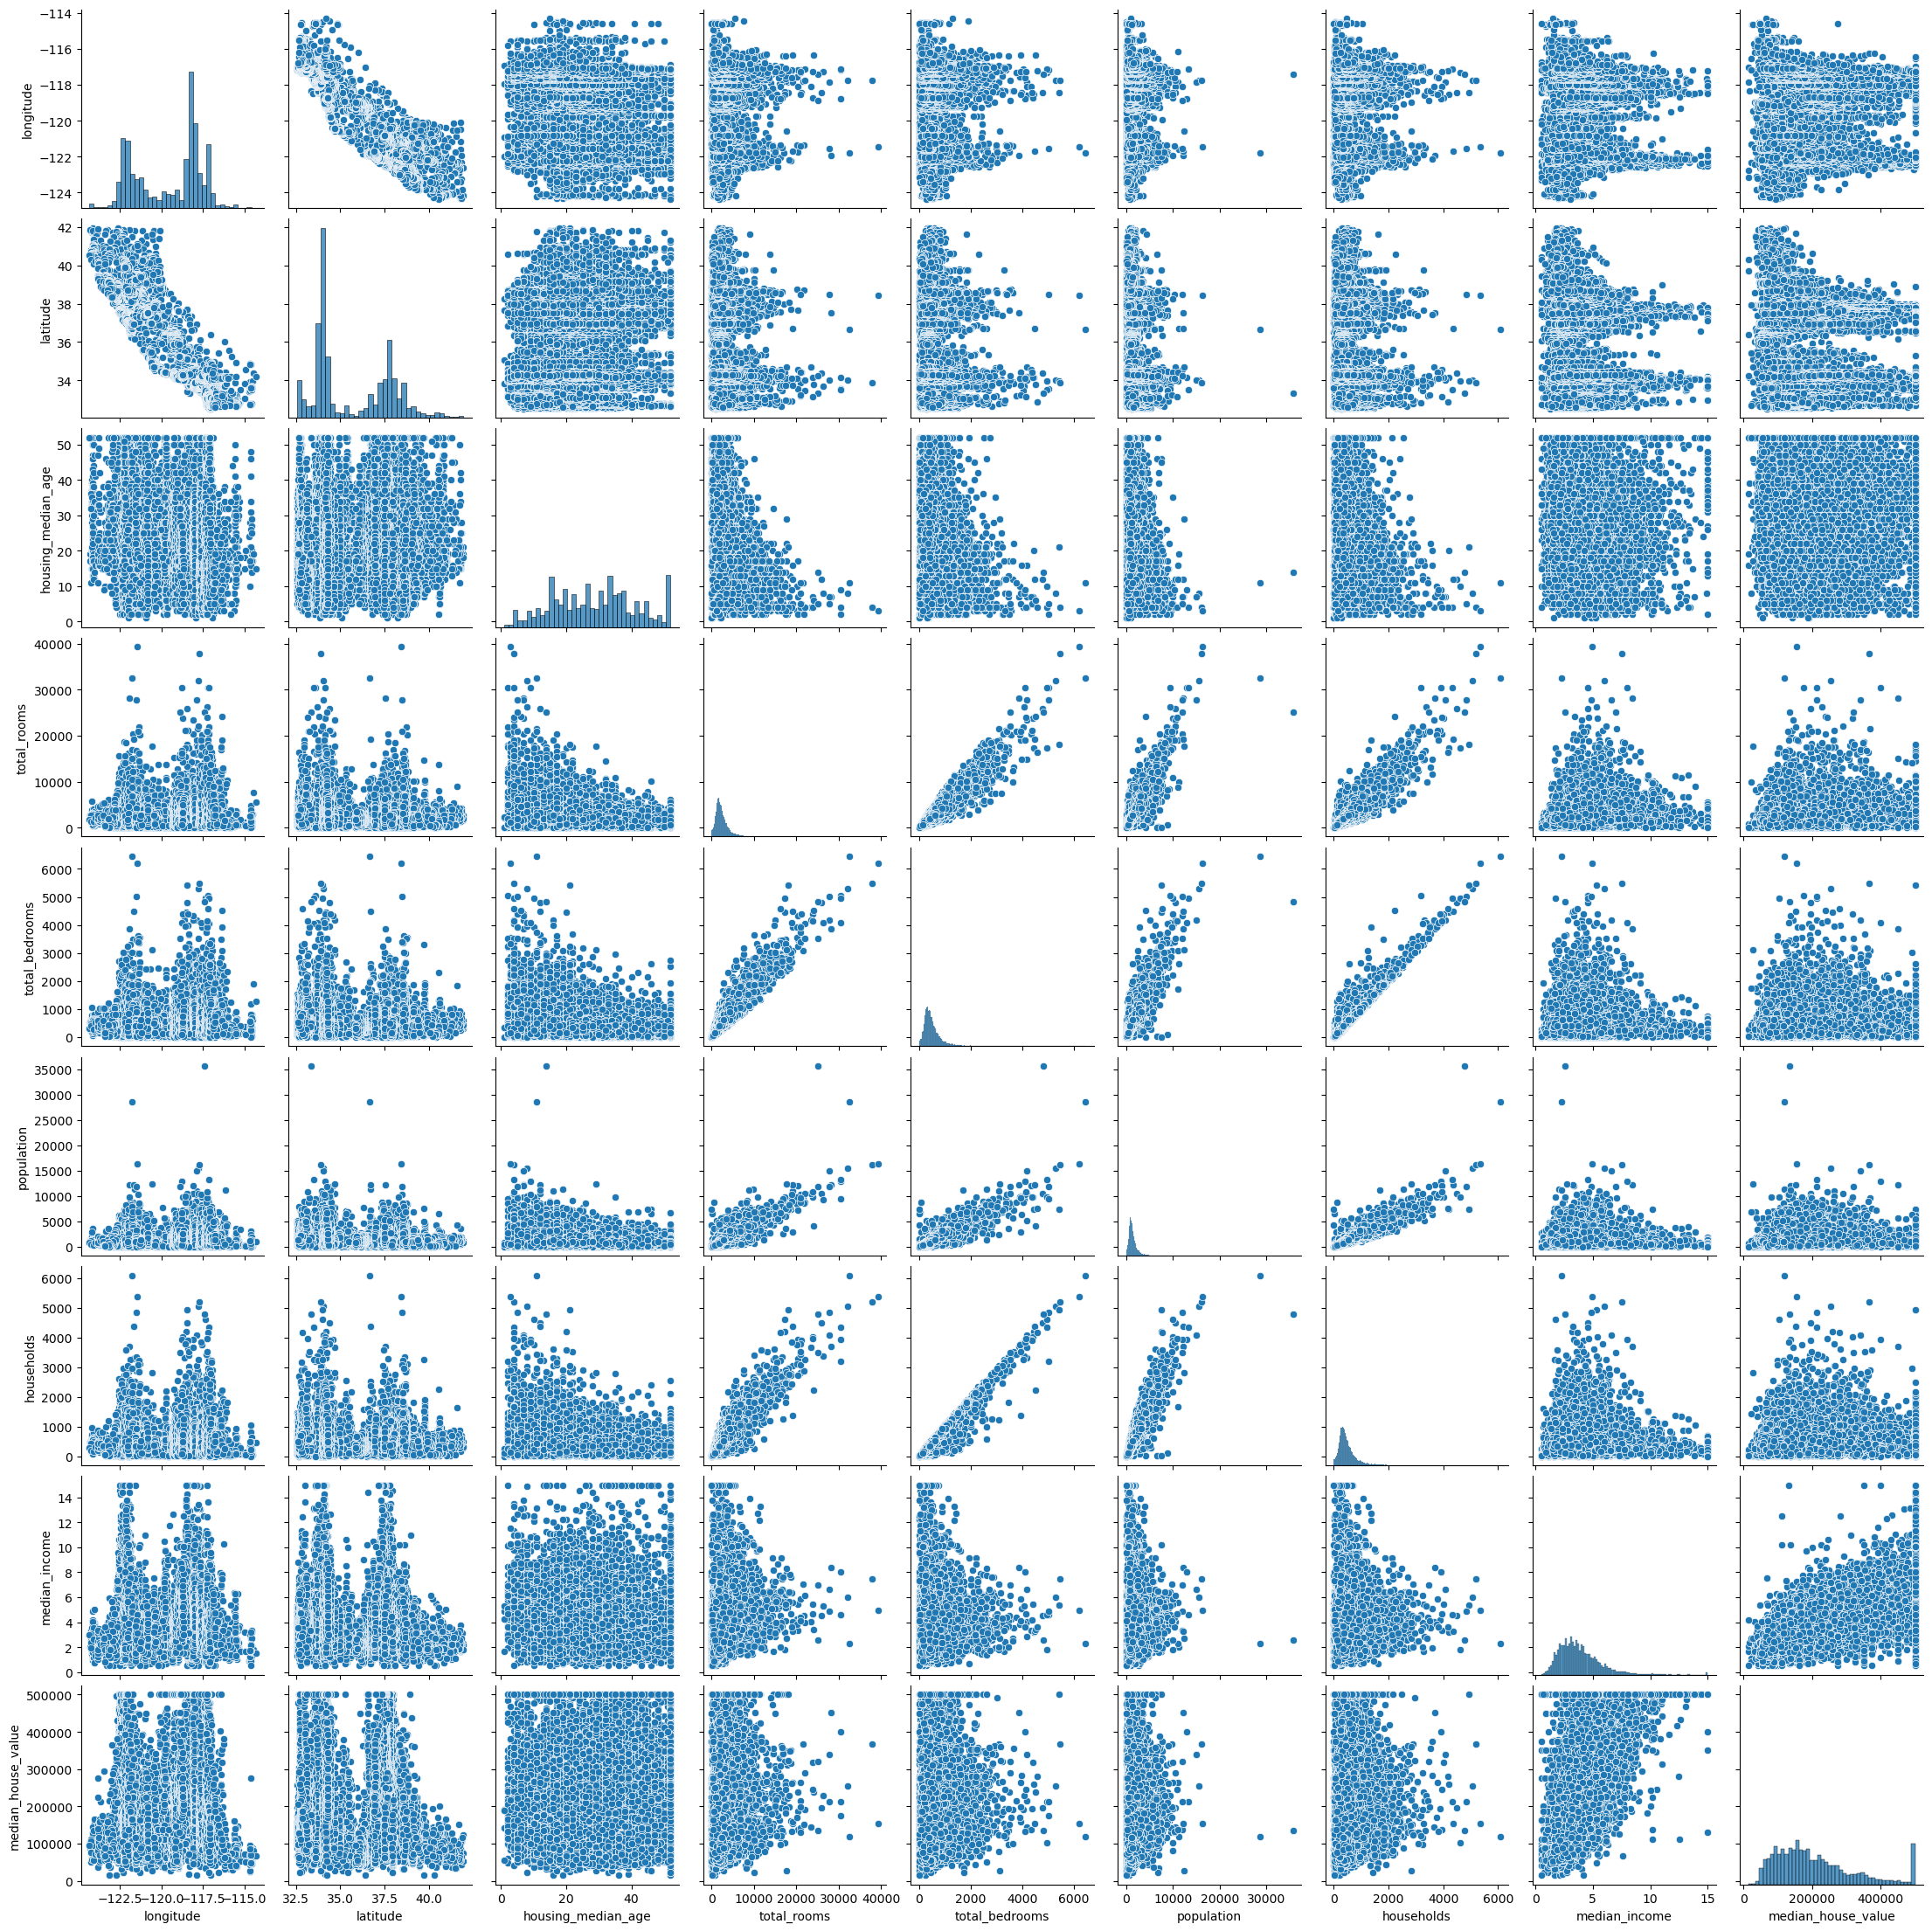

In [20]:
sns.pairplot(data=df)
plt.show()

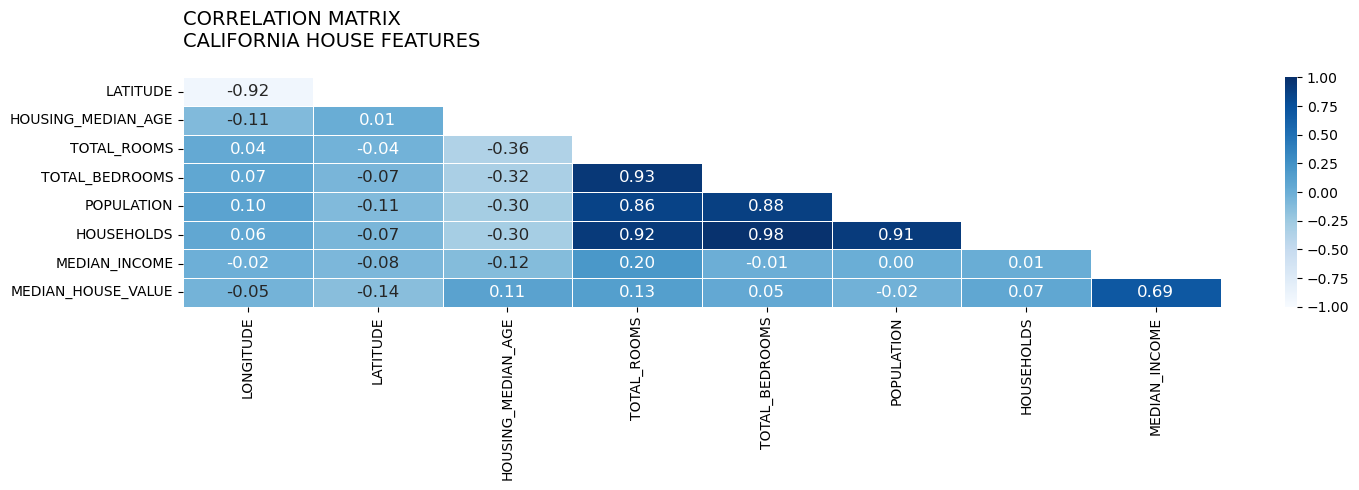

In [21]:
def plot_heatmap(df_corr, title):
  _, ax = plt.subplots(figsize=(15, 5))

  # ones_like can build a matrix of booleans (True, False) with the same shape as our data
  ones_corr = np.ones_like(df_corr, dtype=bool)
  # np's triu: return only upper triangle matrix
  mask = np.triu(ones_corr)
  # When removing the upper tri-angle, here are still two empty cells in our matrix (calories & vitamin)
  adjusted_mask = mask[1:, :-1]
  adjusted_df_corr = df_corr.iloc[1:, :-1]

  sns.heatmap(data=adjusted_df_corr, mask=adjusted_mask,
              annot=True, annot_kws={"fontsize":12}, fmt=".2f", cmap='Blues',
              vmin=-1, vmax=1,
              linecolor='white', linewidths=0.5);

  yticks = [i.upper() for i in adjusted_df_corr.index]
  xticks = [i.upper() for i in adjusted_df_corr.columns]

  ax.set_yticklabels(yticks, rotation=0, fontsize=10);
  ax.set_xticklabels(xticks, rotation=90, fontsize=10);
  title = f'CORRELATION MATRIX\n{title.upper()}\n'
  ax.set_title(title, loc='left', fontsize=14)
  plt.tight_layout()
  plt.show()
corr_matrix=df.corr(numeric_only=True)
plot_heatmap(corr_matrix, 'California House Features')

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [23]:
# Experimenting with Attribute Combinations, especially those that are highly correlated with each other
temp = df.copy()
df["rooms_per_house"] = df["total_rooms"] / df["households"]    # good corr with target
df["bedrooms_ratio"] = df["total_bedrooms"] / df["total_rooms"] # good corr with target
df["people_per_house"] = df["population"] / df["households"]
corr_matrix=df.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False, key=abs)

median_house_value    1.000000
median_income         0.688075
bedrooms_ratio       -0.255880
rooms_per_house       0.151948
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
people_per_house     -0.023737
Name: median_house_value, dtype: float64

In [24]:
df = temp.copy()

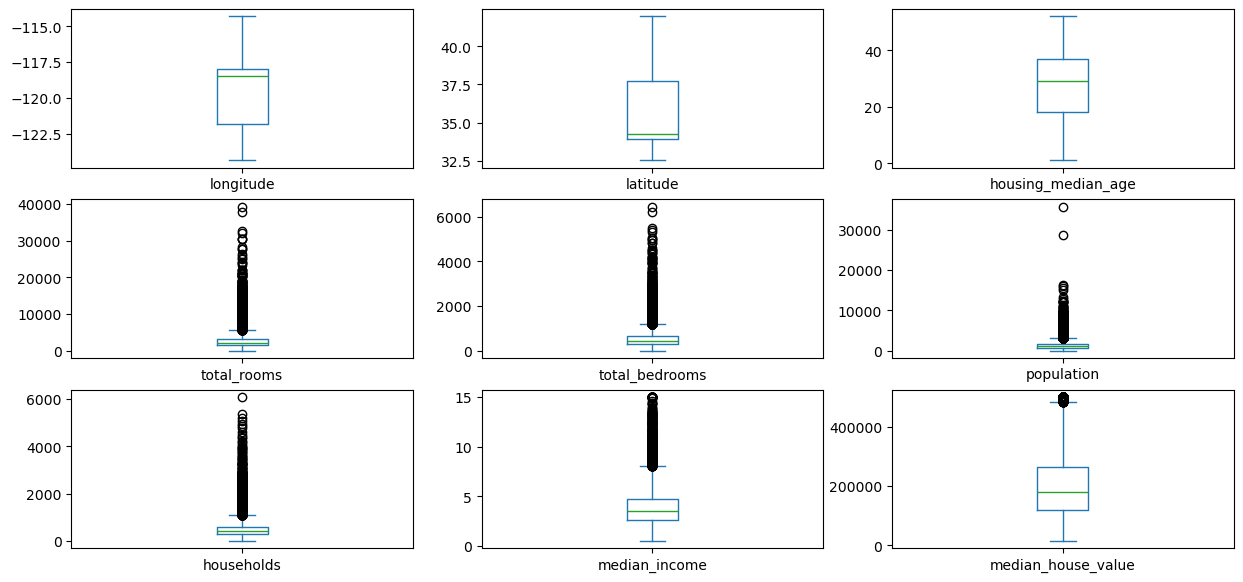

In [25]:
# outlier detection
df.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,7))
plt.show()

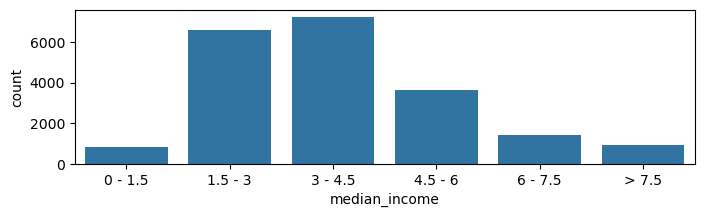

In [26]:
## Try to make median_income into bins
income_bins = pd.cut(df["median_income"],
                     bins=[0, 1.5, 3, 4.5, 6, 7.5, np.inf],
                     labels=["0 - 1.5","1.5 - 3","3 - 4.5","4.5 - 6","6 - 7.5", "> 7.5"])
plt.figure(figsize=(8,2)) 
sns.countplot(x = income_bins)
plt.show()

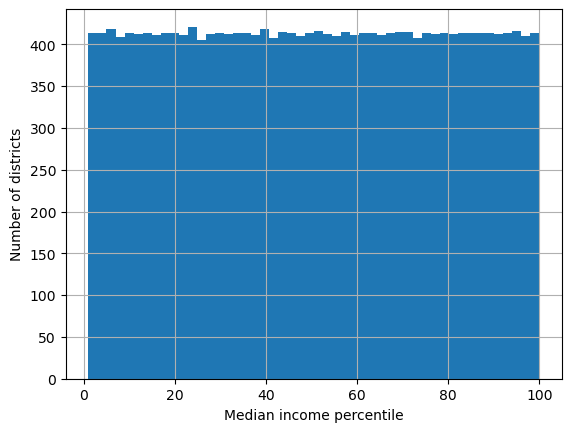

In [27]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(df["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(df["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

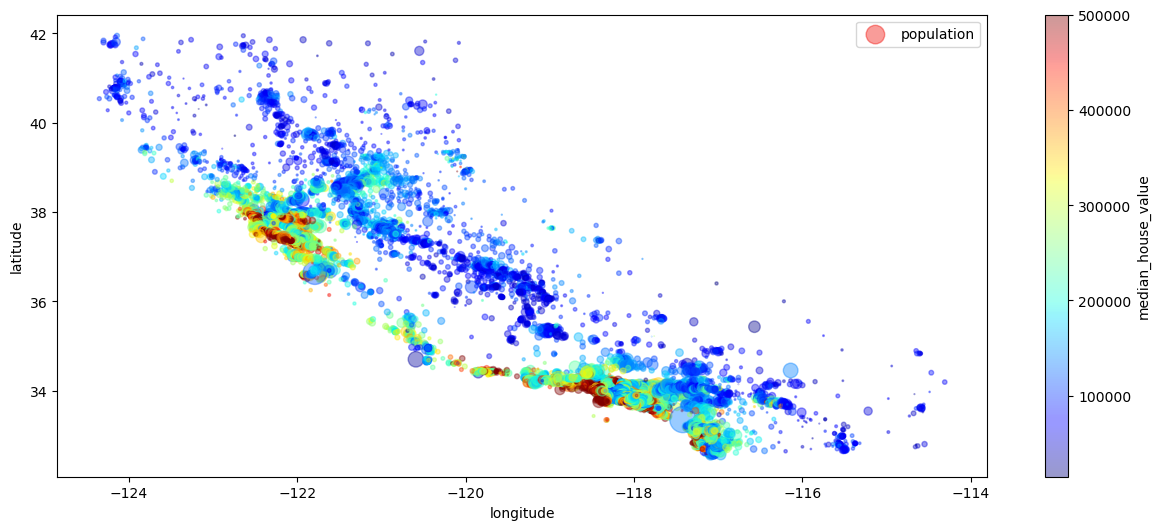

In [28]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=df["population"]/100, label="population", figsize=(15,6),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()
plt.show()

In [29]:
# housing_median_age

from sklearn.metrics.pairwise import rbf_kernel
# the Gaussian RBF similarity between the housing age x and 35
age_simil_35 = rbf_kernel(df[["housing_median_age"]], Y=[[35]], gamma=0.1)


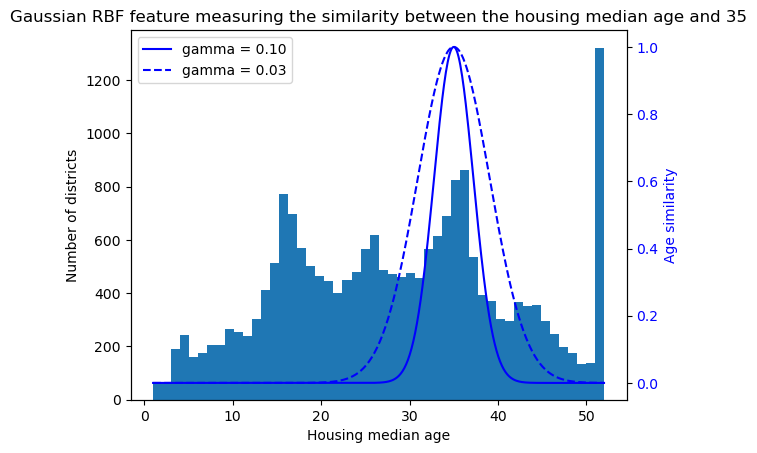

In [30]:
ages = np.linspace(df["housing_median_age"].min(),
                   df["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()
ax1.set_title("Gaussian RBF feature measuring the similarity between the housing median age and 35")
ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(df["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

## Extra

### Custom Transformers
- Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom transformations, cleanup operations, or combining specific attributes.

#### `FunctionTransformer`
- The `inverse_func` argument is optional.
- Custom transformers are also useful to combine features.
- `FunctionTransformer` is very handy, but what if you would like your transformer to be trainable, learning some parameters in the fit() method and using them later in the transform() method? For this, you need to write a **custom class**. 

In [31]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(df["population"])

In [32]:
# Create a transformer that computes the same Gaussian RBF similarity measure 
# Note: that there’s no inverse function for the RBF kernel
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(df[["housing_median_age"]])


In [33]:
# Custom transformers are also useful to combine features.
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

#### Custom Transformer
- Scikit-Learn relies on duck typing, so this class does not have to inherit from any particular base class. 
- All it needs is three methods: 
    - `fit()` (which must return self): 
        - Scikit-Learn pipelines require the fit() method to have two arguments X and y, which is why we need the y=None argument even though we don’t use y.
        - All Scikit-Learn estimators set `n_features_in_` in the `fit()` method, and they ensure that the data passed to `transform()` or `predict()` has this number of features.
        - The `fit()` method must return `self`.
        - All estimators should set `feature_names_in_` in the `fit()` method when they are passed a DataFrame. 
        - All transformers should provide a `get_feature_names_out()` method, as well as an `inverse_transform()` method when their transformation can be reversed. 

    - `transform()`
    - `fit_transform()` You can get fit_transform() for free by simply adding `TransformerMixin` as a base class (the default implementation will just call fit() and then transform())
- If you add `BaseEstimator` as a base class (and avoid using *args and **kwargs in your constructor), you will also get two extra methods: `get_params()` and `set_params()`. 
    - These will be useful for automatic hyperparameter tuning.

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [35]:
# custom transformer that uses a KMeans clusterer in the fit() method to identify the main clusters in the training data, and 
# then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center:

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [36]:
# The transformer uses k-means to locate the clusters, 
# then measures the Gaussian RBF similarity between each district and all 10 cluster centers. 
# The result is a matrix with one row per district, and one column per cluster. 
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df[["latitude", "longitude"]], 
                                           # sample_weight: which lets the user specify the relative weights of the samples
                                           sample_weight=df["median_house_value"] 
                            )


In [37]:
# Let’s look at the first three rows, rounding to two decimal places:
similarities[:3].round(2)

array([[0.  , 0.63, 0.  , 0.  , 0.23, 0.14, 0.  , 0.99, 0.  , 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.23, 0.14, 0.  , 0.99, 0.  , 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.22, 0.13, 0.  , 0.99, 0.  , 0.  ]])

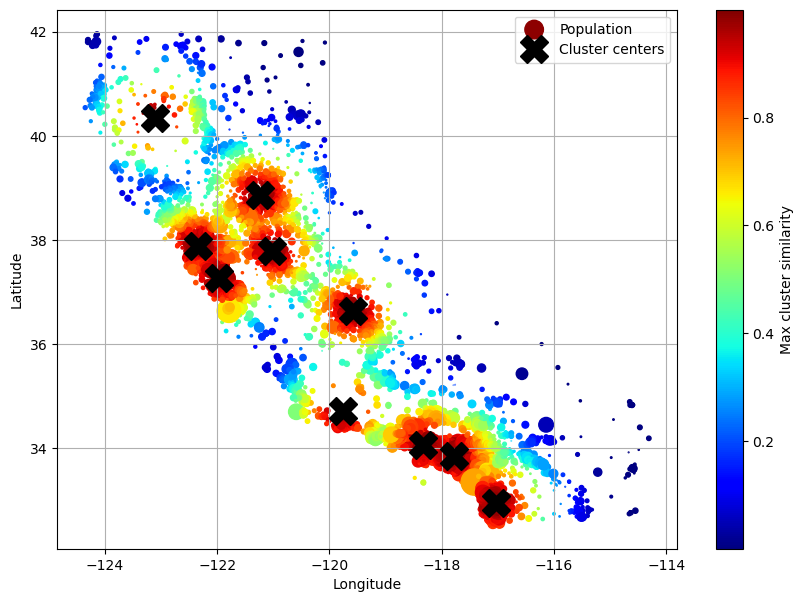

In [38]:

housing_renamed = df.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

- The districts are colored according to their geographic similarity to their closest cluster center. As you can see, most clusters are located in highly populated and expensive areas

### Transformation Pipeline
- Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations.
    - `Pipeline` constructor takes a list of name & estimator tuples defining a sequence of steps
    - If you don’t want to name the transformers, you can use the `make_pipeline()` function instead; 
        - It takes transformers as positional arguments and creates a Pipeline using the names of the transformers’ classes, in lowercase and without underscores 

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [40]:
# Pipelines support indexing
num_pipeline[-1]

StandardScaler()

In [41]:
#  You can also access the estimators via the 'steps' attribute
num_pipeline["impute"]

SimpleImputer(strategy='median')

In [42]:
import sklearn
sklearn.set_config(display="diagram") # enable  all Scikit-Learn estimators as interactive diagrams in Jupyter notebook
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [43]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),  StandardScaler())
num_pipeline


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [44]:
housing_num = df.select_dtypes(include=[np.number])

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.33,  1.05,  0.98, -0.8 , -0.97, -0.97, -0.98,  2.34,  2.13],
       [-1.32,  1.04, -0.61,  2.05,  1.36,  0.86,  1.67,  2.33,  1.31]])

- If you want to recover a nice DataFrame, you can use the pipeline’s get_feature_names_out() method

In [45]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

In [46]:
df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,2.129631
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,1.314156
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.258693
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,1.165100
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,1.172900


### Column Transformer
- It would be more convenient to have a single transformer capable of handling all columns
- `ColumnTransformer` will apply `num_pipeline` (the one we just defined) to the numerical attributes and `cat_pipeline` to the categorical attribute
    - Its constructor requires a list of triplets (3-tuples), each containing 
        - a name (which must be unique and not contain double underscores)
        - a transformer
        - a list of names (or indices) of columns that the transformer should be applied to.
    -  By default, the remaining columns (i.e., the ones that were not listed) will be dropped `remainder="drop"`, but you can set the remainder hyperparameter to any transformer (or to `"passthrough"`) if you want these columns to be handled differently.

In [47]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ],
    remainder='passthrough', # if you want the remaining cols to passthrough
 )

- Since listing all the column names is not very convenient, Scikit-Learn provides a `make_column_selector()` function that returns a selector function you can use to automatically select all the features of a given type, such as numerical or categorical.
- `make_column_transformer()`, which chooses the names for you, just like `make_pipeline()` does. 
    - For example, the following code creates the same `ColumnTransformer` as earlier, except the transformers are automatically named `"pipeline-1"` and `"pipeline-2"` instead of `"num"` and `"cat"`:

In [48]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [49]:
temp = preprocessing.fit_transform(df)


df_prepared = pd.DataFrame(
    temp,
    columns=preprocessing.get_feature_names_out(),
    index=df.index)
df_prepared.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-1__median_house_value,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,2.129631,0.0,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,1.314156,0.0,0.0,0.0,1.0,0.0


## Data Pre-processing

In [50]:
features = numerical_cols + categorical_cols
X = df[features]
y = df[target_col]

# Train, Test, Val Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True, test_size=0.25) # 0.25 x 0.8 = 0.2

In [51]:
class DataPreprocessor:
    def __init__(self, 
                 quantitative_features: List[str], 
                 iqr_bound: float = 1.5,
                 log_target: bool = True,
                ) -> None:
        """_summary_

        Args:
            quantitative_features (List[str]): List of numerical features
            iqr_bound (float, optional): IQR multiplier to set the upper & lower bound. Defaults to 1.5.
        """
        self.quantitative_features: List[str] = quantitative_features
        self.iqr_bound: float = iqr_bound
        self.log_target: bool = log_target

        self.lower_bound: pd.Series = None
        self.upper_bound: pd.Series = None
        

    def fit(self, X: pd.DataFrame):
        """Initialization of the main statistical features. X: X_train"""
        q1 = X[self.quantitative_features].quantile(q=0.25)
        q3 = X[self.quantitative_features].quantile(q=0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - (self.iqr_bound*iqr)
        self.upper_bound = q3 + (self.iqr_bound*iqr)
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        X = self._remove_outliers(X, direction="upper")
        if self.log_target:
            y = self._log_transform(y)
        return X, y
    
    def _log_transform(self, y: pd.Series) -> pd.Series:
        """Log the target

        Args:
            y (pd.Series): target column

        Returns:
            pd.Series: log(1+y)
        """
        return np.log1p(y)
    
    def _remove_outliers(self, X: pd.DataFrame, direction: str = "both") -> pd.DataFrame:
        """This is to cap the outlier with the lower & upper bounds

        Args:
            X (pd.DataFrame): X
            direction (str, optional): Direction of outlier detection. 
                Defaults to "both". Other option: "lower", "upper"

        Returns:
            pd.DataFrame: _description_
        """
        for col in self.quantitative_features:
            lower_bound = self.lower_bound[col]
            upper_bound = self.upper_bound[col]
            if direction == "both":
                X.loc[X[col] > upper_bound, col] = upper_bound
                X.loc[X[col] < lower_bound, col] = lower_bound
            if direction == "lower":
                X.loc[X[col] < lower_bound, col] = lower_bound
            if direction == "upper":
                X.loc[X[col] > upper_bound, col] = upper_bound
        return X


base_de = DataPreprocessor(numerical_cols, log_target=False)
base_de.fit(X_train)
X_train, y_train = base_de.transform(X_train, y_train)
X_test, y_test = base_de.transform(X_test, y_test)
X_val, y_val = base_de.transform(X_val, y_val)

In [97]:
from sklearn.preprocessing import KBinsDiscretizer

def column_ratio(X):
    # This function takes a 2D array X and 
    # returns the ratio of the values in the first column to the values in the second column.
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    # '__ratio' to be appended 
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

    
def binning_pipeline(n_bins, encode, strategy): 
    return make_pipeline(
        SimpleImputer(strategy="median"),
        KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    )


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"), # to get the same feature names
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessor = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        # ("bin_ord", binning_pipeline(10, 'ordinal', 'quantile'), ["median_income"]),
        # ("bin", binning_pipeline(7, 'onehot', 'quantile'), ["housing_median_age"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                             "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [53]:
preprocessor.fit(X_train)

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x28b716d40>,
                                                                      func=<function column_ratio at 0...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28d0e2490>)])

In [54]:
preprocessor.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Model Training

In [55]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

### Baseline Model
- Look at the work of the following models (without hyperparameter tuning):
    - LinearRegression
    - Ridge
    - Lasso
    - ElasticNet
    - GradientBoostingRegressor
    - RandomForestRegressor
    - XGBRegressor
- Numerical + Categorical: `XGBRegressor - rmse=48633.821` (One-hot encoding)
- Numerical + Categorical + Log Long Tail Feature: `XGBRegressor - rmse=48826.338`
- Numerical + Categorical + Log Long Tail Feature + Geo: `XGBRegressor - rmse=47953.038`
- Numerical + Categorical + Geo: `XGBRegressor - rmse=47926.314`
- Numerical + Categorical + Geo + Ratio: `XGBRegressor - rmse=46384.976`
- Conclusion: 
    - Linear models have high rmse, but less being overfitted on the train set
    - Ensemble models & XGBoost have low rmse, but tend to be overfitted

In [56]:
model_list = [
               LinearRegression(), Ridge(), Lasso(), ElasticNet(), 
               GradientBoostingRegressor(), RandomForestRegressor(),
               XGBRegressor()
            ]

In [57]:
class Trainer:
    def __init__(self, 
                 model_list: List,
                 preprocessor) -> None:
        self.model_list = model_list
        self.preprocessor = preprocessor
        
    def make_pipeline(self, model):
        return Pipeline(steps=[
                                ('preprocessor', self.preprocessor),
                                ('regressor',  model)
                ])

    def fit_and_evaluate(self, X_train, y_train, X_val, y_val, cv=5) -> pd.DataFrame:
        baseline_results = pd.DataFrame(columns=['model_name', 'rmse_train_cv', 'rmse_val'])
        for model in tqdm(model_list):
            clf = self.make_pipeline(model)
            # using cross_val_score
            rmse_train = np.round(
                            np.mean(
                                -cross_val_score(clf, X_train, y_train,
                                scoring="neg_root_mean_squared_error", cv=cv)
                            ), 5
                        )
            # test on val_set
            clf.fit(X_train, y_train)
            y_pred_val = clf.predict(X_val)
            rmse_val = self.cal_rmse(y_val, y_pred_val)
            baseline_results.loc[len(baseline_results)] = [model.__class__.__name__, rmse_train, rmse_val]
        return baseline_results \
                    .sort_values(by='rmse_val', ascending=False) \
                    .set_index('model_name')
    
    def cal_rmse(self, y, y_pred) -> float:
        return np.round(np.sqrt(mean_squared_error(y, y_pred)),3)

In [88]:
base_trainer = Trainer(model_list, preprocessor)

In [89]:
baseline_results = base_trainer.fit_and_evaluate(X_train, y_train, X_val, y_val)

100%|██████████| 7/7 [01:44<00:00, 14.97s/it]


In [90]:
baseline_results

,rmse_train_cv,rmse_val
model_name,,
ElasticNet,95336.40505,84331.324
Lasso,89257.93418,69317.232
LinearRegression,89342.99481,69315.256
Ridge,88916.90299,69268.318
GradientBoostingRegressor,52872.63095,53386.639
RandomForestRegressor,48709.65537,48097.471
XGBRegressor,48052.32570,46787.694


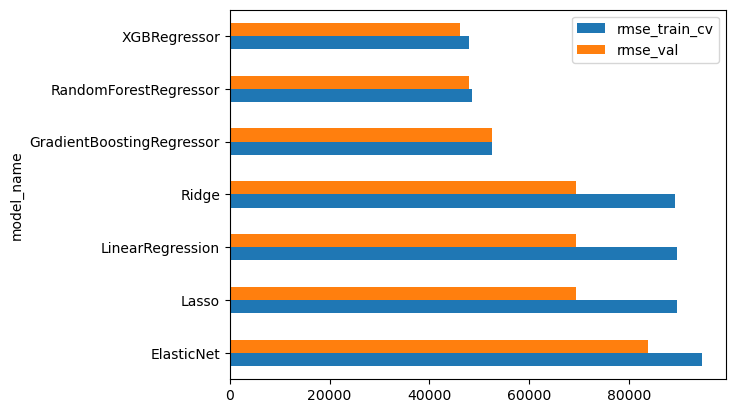

In [61]:
baseline_results.plot(kind='barh')
plt.show()

## Fine-Tune Model

### Grid Search

In [98]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgboost", XGBRegressor(random_state=42)),
])


In [ ]:
param_grid = [
    {
        'preprocessor__geo__gamma': [0.01, 0.1, 1],
        'preprocessor__geo__n_clusters': [5, 8, 10],
        'xgboost__max_depth': [6, 7, 10],
        'xgboost__learning_rate': [0.008, 0.01, 0.02]
    },
    {
        'preprocessor__geo__n_clusters': [10,15],
        'xgboost__max_depth': [6, 8, 10]
    },
    
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

In [75]:
grid_search.best_params_

{'preprocessor__geo__n_clusters': 10, 'xgboost__max_depth': 6}

In [77]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessor__geo__gamma","param_preprocessor__geo__n_clusters",
                 "param_xgboost__max_depth", "param_xgboost__learning_rate", "split0_test_score",
                 "split1_test_score", "split2_test_score",  
                 "mean_test_score"]]
score_cols = ["split0", "split1", "split2","mean_test_rmse"]
cv_res.columns = ["gamma", "n_clusters", "max_depth","learning_rate"] + score_cols # rename
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,gamma,n_clusters,max_depth,learning_rate,split0,split1,split2,mean_test_rmse
81,NaN,10,6,NaN,49937,47760,47187,48295
84,NaN,15,6,NaN,49777,47449,48153,48460
82,NaN,10,8,NaN,50312,47543,47940,48598
85,NaN,15,8,NaN,49647,47747,48455,48616
86,NaN,15,10,NaN,50651,47897,49525,49358


In [78]:
np.round(np.sqrt(mean_squared_error(y_val, grid_search.best_estimator_.predict(X_val))),3)

46191.898

### Randomized Search 
- Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessor__geo__n_clusters': randint(low=3, high=50),
                  'xgboost__max_depth': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_o...
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=42, ...))]),
                   param_distributions={'preprocessor__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2883047d0>,
                                        'xgboost__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x288307590>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [100]:
rnd_search.best_params_

{'preprocessor__geo__n_clusters': 42, 'xgboost__max_depth': 4}

In [101]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessor__geo__n_clusters",
                 "param_xgboost__max_depth", "split0_test_score",
                 "split1_test_score", "split2_test_score", 
                 "mean_test_score"]]
score_cols = ["split0", "split1", "split2","mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_depth"] + score_cols # rename
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_depth,split0,split1,split2,mean_test_rmse
5,42,4,48385,45707,46676,46923
8,32,7,48861,46915,47266,47681
4,13,5,49657,47183,47368,48069
2,23,8,48759,47437,48546,48248
1,45,9,49587,47399,47760,48249


In [102]:
final_model = rnd_search.best_estimator_  # includes preprocessing

In [103]:
np.round(mean_squared_error(y_val, final_model.predict(X_val), squared=False),3)

46643.994

### Best Model Analysis

In [104]:
feature_importances = final_model["xgboost"].feature_importances_
sorted(zip(feature_importances,
           final_model["preprocessor"].get_feature_names_out()),
           reverse=True)[:10]


[(0.3590697, 'cat__ocean_proximity_INLAND'),
 (0.12517498, 'log__median_income'),
 (0.0626268, 'geo__Cluster 20 similarity'),
 (0.052247293, 'cat__ocean_proximity_NEAR OCEAN'),
 (0.03096777, 'geo__Cluster 23 similarity'),
 (0.03000113, 'geo__Cluster 25 similarity'),
 (0.027027654, 'people_per_house__ratio'),
 (0.025447354, 'geo__Cluster 9 similarity'),
 (0.020791346, 'geo__Cluster 13 similarity'),
 (0.01361011, 'remainder__housing_median_age')]

In [107]:
# Evaluate on Test set
final_predictions = final_model.predict(X_test)
final_rmse = np.round(mean_squared_error(y_test, final_predictions, squared=False),3)
print(final_rmse)

47994.367


In [108]:
# We can compute a 95% confidence interval for the test RMSE:

from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45853.40210444, 50043.82031272])

### Optuna

In [73]:
def objective(trial):
    param = {
        # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        # 'sampling_method': 'gradient_based',
        # 'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
        # 'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        # 'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        # 'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]), #  0.02 is the best
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        # 'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        # 'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        # 'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),  
        #'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),  
        # 'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'random_state': 42
    }
    preprocessor = fe_trainer.preprocessor.fit(X_train_fe)
    
    model = XGBRegressor(**param)  

    model.fit(preprocessor.transform(X_train_fe), y_train, 
            eval_set=[(preprocessor.transform(X_val_fe), y_val)], 
            early_stopping_rounds=10, 
            verbose=False,
    )
    
    y_pred = model.predict(preprocessor.transform(X_test_fe))
    
    return np.sqrt(mean_squared_error(y_test, y_pred))


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,  timeout=600)

[I 2023-12-14 18:10:09,200] A new study created in memory with name: no-name-04fa16b6-dad8-42a7-8524-cbc67be0d9a3
[W 2023-12-14 18:10:09,201] Trial 0 failed with parameters: {'learning_rate': 0.016} because of the following error: NameError("name 'fe_trainer' is not defined").
Traceback (most recent call last):
  File "/Users/codexplore/miniforge3/envs/ml_env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/10/n2pk9skj29l6tsds0vmch5lm0000gn/T/ipykernel_17301/3181714080.py", line 18, in objective
    preprocessor = fe_trainer.preprocessor.fit(X_train_fe)
                   ^^^^^^^^^^
NameError: name 'fe_trainer' is not defined
[W 2023-12-14 18:10:09,202] Trial 0 failed with value None.


NameError: name 'fe_trainer' is not defined

In [ ]:
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key} : {value}, ")

Number of finished trials: 50
Best trial:
  Value: 1.5712115164171174
  Params: 
    learning_rate : 0.02, 


In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(template='plotly_dark', title='<b>Hyperparameter Importances', title_x=0.5)

In [ ]:
model = XGBRegressor(**study.best_params) 

In [ ]:
preprocessor = fe_trainer.preprocessor.fit(X_train_fe)
model.fit(preprocessor.transform(X_train_fe), y_train)
y_val_pred = model.predict(preprocessor.transform(X_val_fe))
y_test_pred = model.predict(preprocessor.transform(X_test_fe))

In [ ]:
np.sqrt(mean_squared_error(y_val, y_val_pred))

1.5683636053380048

In [ ]:
np.sqrt(mean_squared_error(y_test, y_test_pred))

1.5712115164171174

In [ ]:
encoded_features = list(preprocessor.get_feature_names_out())
encoded_features = {f"f{idx}": col_name for idx, col_name in enumerate(encoded_features)}

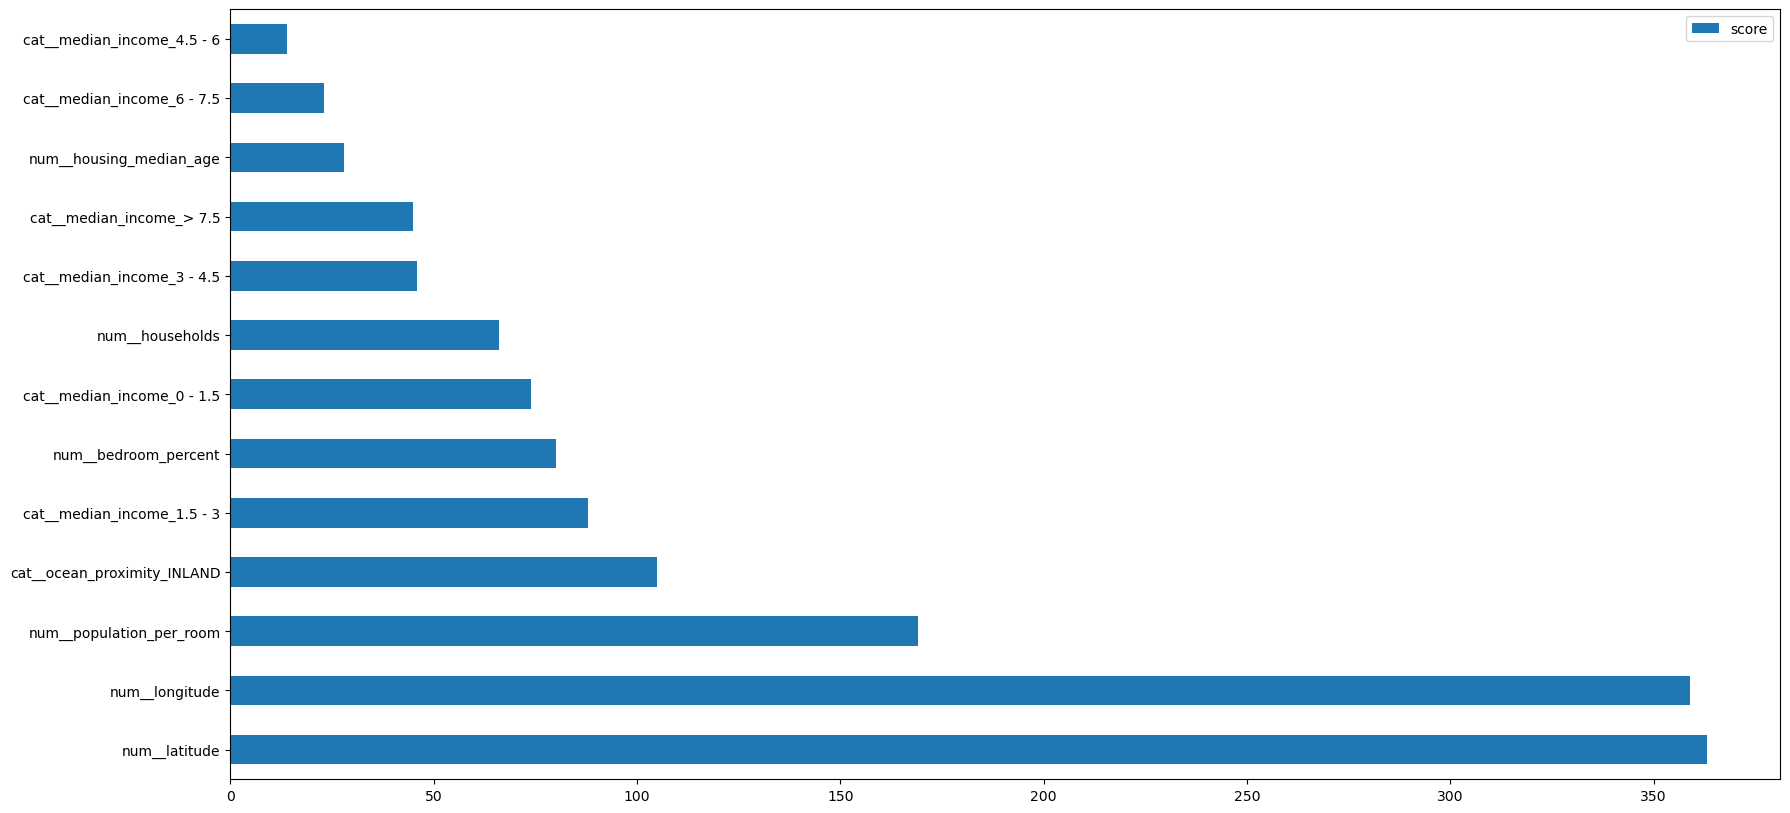

In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = [encoded_features[k] for k in list(feature_important.keys())]
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))
plt.show()